# polly

Example notebook

Jake Pember
2024-06-14

This notebook demonstrates the use of the KPF etalon analysis code polly

---
### Dependencies

```
numpy
astropy
scipy
matplotlib
tqdm
```

---
### Imports

In [1]:
from __future__ import annotations
from pathlib import Path
from glob import glob
from astropy.io import fits
from matplotlib import pyplot as plt

try:
    from polly.etalonanalysis import Spectrum
    from polly.plotStyle import plotStyle
except ImportError:
    from etalonanalysis import Spectrum
    from plotStyle import plotStyle
plt.style.use(plotStyle)

`polly` has a class structure of `Spectrum` <-> `Order` <-> `Peak` objects. All normal interfacing can be done at the `Spectrum` level, where functions initiate calls at lower levels, or access data from lower levels to be returned by the `Spectrum`.

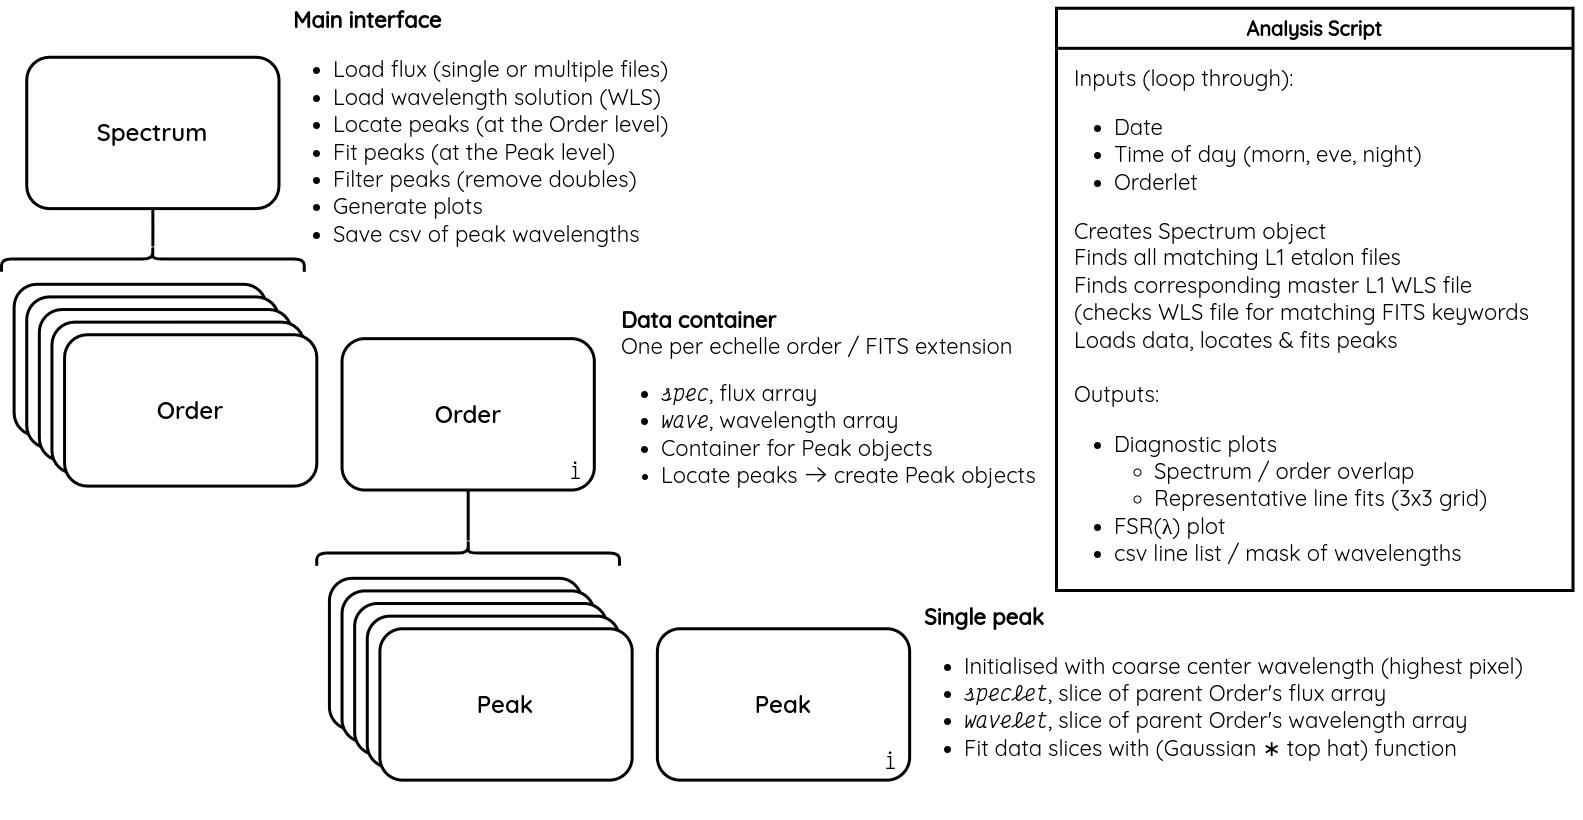

Set up all the master variables. These are nominally passed in within a `.cfg` file

In [2]:
OUTDIR: str = "/scr/jpember/temp"
# Make OUTDIR if it does not exist yet
Path(f"{OUTDIR}").mkdir(parents=True, exist_ok=True)

ORDERLETS : list[str] = [
    # "SCI1",
    "SCI2",
    # "SCI3",
    # "CAL",
    # "SKY",
    ]

DATES = [f"202405{x:02}" for x in range(1, 2)]
TIMESOFDAY = [
    "morn",
    # "eve",
    # "night",
    ]

---

### Batch processing example

This is adapted from the `run_analysis_batch.py` script

In [3]:
def find_L1_etalon_files(DATE: str, TIMEOFDAY: str) -> dict[str, list[str]]:
    """
    Look at all L1 files for the given date, and find the etalon files
    
    Better done as a database query
    """
    
    all_files: list[str] = glob(f"/data/kpf/L1/{DATE}/*.fits")
    
    out_files: list[str] = []
    
    for f in all_files:
        object = fits.getval(f, "OBJECT")
        if "etalon" in object.lower():
            timeofday = object.split("-")[-1]
            if timeofday == TIMEOFDAY:
                out_files.append(f)
                
    return out_files

In [ ]:
for DATE in DATES:
    for TIMEOFDAY in TIMESOFDAY:
        for ORDERLET in ORDERLETS:
            files = find_L1_etalon_files(DATE=DATE, TIMEOFDAY=TIMEOFDAY)
            if not files:
                print("No files found for {DATE} {TIMEOFDAY}")
                continue
            s = Spectrum(
                spec_file = files,
                # corresponding WLS file will be located automatically, matching
                # the date and time of day. wls_file can also be passed explicitly
                # to force the wavelength solution to be used.
                wls_file = None,
                orderlet = ORDERLET
                )
            s.locate_peaks(fractional_height=0.01, window_to_save=10)
            s.fit_peaks(type="conv_gauss_tophat")
            s.filter_peaks(window=0.1)
            
            Path(f"{OUTDIR}").mkdir(parents=True, exist_ok=True) # Make OUTDIR
            s.save_peak_locations(
                f"{OUTDIR}/{DATE}_{TIMEOFDAY}_{ORDERLET}_etalon_wavelengths.csv"
                )

            # Spectrum plot, showing the overlap between two orders
            fig = plt.figure(figsize=(12, 4))
            ax = fig.gca()
            ax.set_title(f"{DATE} {TIMEOFDAY} {ORDERLET}")
            ax.set_xlim(500, 502)
            s.plot_spectrum(ax=ax)
            plt.show()
            plt.close()

            # FSR plot
            fig = plt.figure(figsize=(12, 4))
            ax = fig.gca()
            ax.set_title(f"{DATE} {TIMEOFDAY} {ORDERLET}")
            s.plot_FSR(ax=ax)
            plt.show()
            plt.close()

---

### Single-file processing example

The simpler way to run `polly` is for just a single file. Here a `Spectrum` object is created, and filenames for the `spec_file` and `wls_file` are passed in explicitly. This is how you can force the analysis to use a particular wavelength solution.

The `Spectrum` class's methods can also be chained. Each of the key methods returns the `Spectrum` object itself. For this reason, ending a notebook cell with some `Spectrum` method may result in a large output, and so you can just insert and empty string to prevent this.

In [3]:
# Load a particular master etalon file, and explicitly the corresponding WLS file 

DATE = "20240501"
TIMEOFDAY = "morn"
ORDERLET = "CAL"

example_spec_file = f"/data/kpf/masters/{DATE}/kpf_{DATE}_master_WLS_autocal-etalon-all-{TIMEOFDAY}_L1.fits"
example_wls_file  = f"/data/kpf/masters/{DATE}/kpf_{DATE}_master_WLS_autocal-lfc-all-{TIMEOFDAY}_L1.fits"

s = Spectrum(spec_file=example_spec_file, wls_file=example_wls_file, orderlet=ORDERLET)
s.locate_peaks().fit_peaks().filter_peaks().save_peak_locations(f"{OUTDIR}/test.csv")

Loading flux values from a single file... DONE
Locating CAL peaks... DONE
Fitting CAL peaks with conv_gauss_tophat function...


Orders: 100%|██████████| 67/67 [15:29<00:00, 13.87s/it]


Filtering CAL peaks to remove identical peaks appearing in adjacent orders... DONE
Saving CAL peaks to /scr/jpember/temp/test.csv... DONE


Spectrum with 67 Orders and 13188 total Peaks

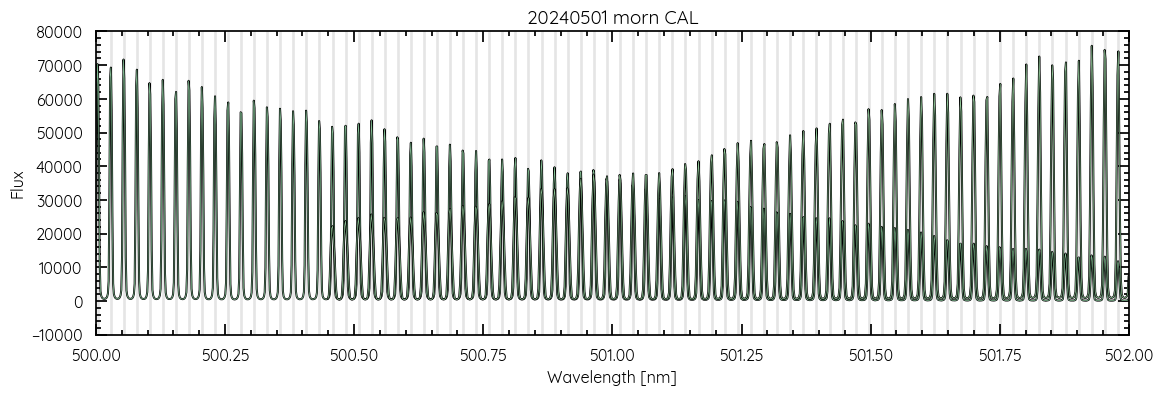

<Figure size 529.134x377.953 with 0 Axes>

In [15]:
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()
ax.set_title(f"{DATE} {TIMEOFDAY} {ORDERLET}")
ax.set_xlim(500, 502)
s.plot_spectrum(ax=ax)
plt.savefig("/scr/jpember/example_spectrum_500nm.png")

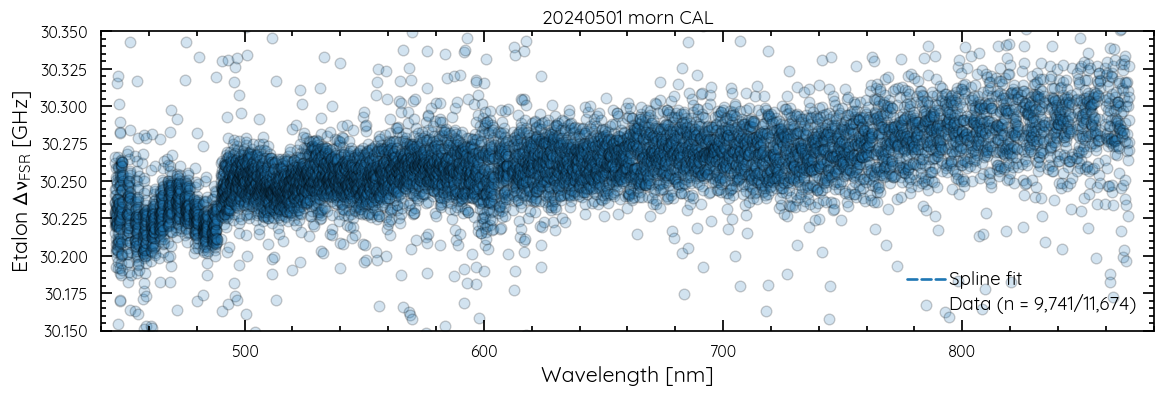

Spectrum with 67 Orders and 13186 total Peaks

In [8]:
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()
ax.set_title(f"{DATE} {TIMEOFDAY} {ORDERLET}")
s.plot_FSR(ax=ax)